# Sales Prediction Case Study

## Setups

### Git control setup

In [2]:
%run github_utils.ipynb

In [3]:
git_manager = GitHubManager()

Could not retrieve all credentials from Colab secrets: Secret GITHUB_USERNAME does not exist.
Enter your GitHub username: ··········
Enter your GitHub email: ··········
Enter your GitHub personal access token: ··········
Enter repository name (or press Enter to skip): sales_forecast_multiple_keys
Git configured successfully


In [8]:
git_manager.clone_repo("sales_forecast_multiple_keys")

Cloning repository 'sales_forecast_multiple_keys' to '/content/sales_forecast_multiple_keys'...
Repository cloned successfully


In [10]:
git_manager.status()

"On branch main\nYour branch is up to date with 'origin/main'.\n\nnothing to commit, working tree clean\n"

### Importers

In [46]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import LabelEncoder
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

### UDFs

In [99]:
def calculate_wmape(y_true, y_pred):
    """
    Calculate Weighted Mean Absolute Percentage Error (WMAPE)
    WMAPE = 1 - SUM(Absolute Error)/SUM(Sales)
    """
    # Convert to numpy arrays to ensure proper calculation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Check if denominator is zero
    if np.sum(y_true) == 0:
        print("Warning: Sum of actual values is zero. Cannot calculate WMAPE.")
        return np.nan

    return 1 - np.sum(np.abs(y_true - y_pred)) / np.sum(y_true)

def calculate_bias(y_true, y_pred):
    """
    Calculate prediction bias
    Bias = (SUM(Sales)/SUM(Prediction) - 1)
    """
    # Convert to numpy arrays to ensure proper calculation
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Check if denominator is zero
    if np.sum(y_pred) == 0:
        print("Warning: Sum of predictions is zero. Cannot calculate Bias.")
        return np.nan

    return (np.sum(y_true) / np.sum(y_pred)) - 1

def convert_yearweek(yearweek):
    """Convert YYYY-WW format to datetime"""
    year, week = map(int, yearweek.split('-'))
    # Create a date for January 1st of the given year
    jan1 = pd.Timestamp(f'{year}-01-01')
    # Find the Monday of the week containing Jan 1
    monday_of_jan1_week = jan1 - pd.Timedelta(days=jan1.dayofweek)
    # Adjust to get the first Monday of the ISO week
    if jan1.isocalendar()[1] > 1:
        week1_start = monday_of_jan1_week
    else:
        week1_start = monday_of_jan1_week + pd.Timedelta(weeks=1)
    # Calculate the start of the target week
    return week1_start + pd.Timedelta(weeks=week-1)

def create_cyclical_features(df, col, period):
    """Create sin and cos features to represent cyclical data"""
    df[f'{col}_sin'] = np.sin(2 * np.pi * df[col]/period)
    df[f'{col}_cos'] = np.cos(2 * np.pi * df[col]/period)
    return df

def target_encode(df, col, target, smoothing=10):
    """
    Target encoding with smoothing.
    Smoothing helps prevent overfitting with small groups.
    """
    # Calculate global mean
    global_mean = df[target].mean()

    # Group by the category and calculate mean
    category_means = df.groupby(col)[target].agg(['mean', 'count'])

    # Apply smoothing
    smoothed_means = (category_means['count'] * category_means['mean'] +
                      smoothing * global_mean) / (category_means['count'] + smoothing)

    # Map the encoded values back
    encoded_col = df[col].map(smoothed_means)

    return encoded_col

def remove_collinear_features(df, threshold=0.9):
    """
    Remove highly correlated features to reduce multicollinearity.
    """
    # Calculate correlation matrix
    corr_matrix = df.corr().abs()

    # Select upper triangle of correlation matrix
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

    # Find features with correlation greater than threshold
    to_drop = [column for column in upper.columns if any(upper[column] > threshold)]

    print(f"Dropping {len(to_drop)} highly correlated features: {to_drop}")

    # Drop features
    df_reduced = df.drop(columns=to_drop)

    return df_reduced, to_drop


## Data Loader

In [49]:
# Load data
print("Loading and preprocessing data...")
df = pd.read_csv('sales_pred_case.csv')

Loading and preprocessing data...


### Data exploration

In [59]:
print(f"Data shape: {df.shape}")
print(f"Number of unique Keys: {df['Key'].nunique()}")
print(f"Date range: {df['YearWeek'].min()} to {df['YearWeek'].max()}")
print("Number of unique YearWeeks:", df['YearWeek'].nunique())
print("\nMissing values per column:")
print(df.isnull().sum())
df.head()

Data shape: (143273, 20)
Number of unique Keys: 970
Date range: 2020-01 to 2023-03
Number of unique YearWeeks: 160

Missing values per column:
Key                0
YearWeek           0
Sales              0
Material           0
Customer           0
CustomerGroup      0
Category           0
Week               0
Month              0
Qtr                0
New_Year           0
Christmas_Day      0
Easter_Monday      0
Other_Holidays     0
DiscountedPrice    0
PromoShipment      0
Objective1         0
Objective2         0
PromoMethod        0
PromoStatus        0
dtype: int64


,Key,YearWeek,Sales,Material,Customer,CustomerGroup,Category,Week,Month,Qtr,New_Year,Christmas_Day,Easter_Monday,Other_Holidays,DiscountedPrice,PromoShipment,Objective1,Objective2,PromoMethod,PromoStatus
0,0_25,2020-03,2.0,0,25,13,0,3,1,1,0,0,0,0,5.92,0,7,3,8,7
1,0_25,2020-04,0.0,0,25,13,0,4,1,1,0,0,0,0,0.00,0,7,3,8,7
2,0_25,2020-05,0.0,0,25,13,0,5,2,1,0,0,0,0,0.00,0,7,3,8,7
3,0_25,2020-06,0.0,0,25,13,0,6,2,1,0,0,0,0,0.00,0,7,3,8,7
4,0_25,2020-07,0.0,0,25,13,0,7,2,1,0,0,0,0,0.00,0,7,3,8,7


In [54]:
# Summary statistics
print("\nSummary Statistics:")
df.describe().T


Summary Statistics:


,count,mean,std,min,25%,50%,75%,max
Sales,143273.0,226.232961,640.523581,0.00,0.0,0.0,160.000000,21450.0
Material,143273.0,100.433906,49.288938,0.00,63.0,107.0,144.000000,182.0
Customer,143273.0,15.740258,9.078910,0.00,10.0,15.0,25.000000,32.0
CustomerGroup,143273.0,10.460589,6.190107,0.00,5.0,10.0,15.000000,21.0
Category,143273.0,0.000000,0.000000,0.00,0.0,0.0,0.000000,0.0
Week,143273.0,26.856323,15.174052,1.00,14.0,27.0,40.000000,53.0
Month,143273.0,6.597070,3.453950,1.00,4.0,7.0,10.000000,12.0
Qtr,143273.0,2.526757,1.120696,1.00,2.0,3.0,4.000000,4.0
New_Year,143273.0,0.021141,0.143856,0.00,0.0,0.0,0.000000,1.0
Christmas_Day,143273.0,0.025678,0.158174,0.00,0.0,0.0,0.000000,1.0


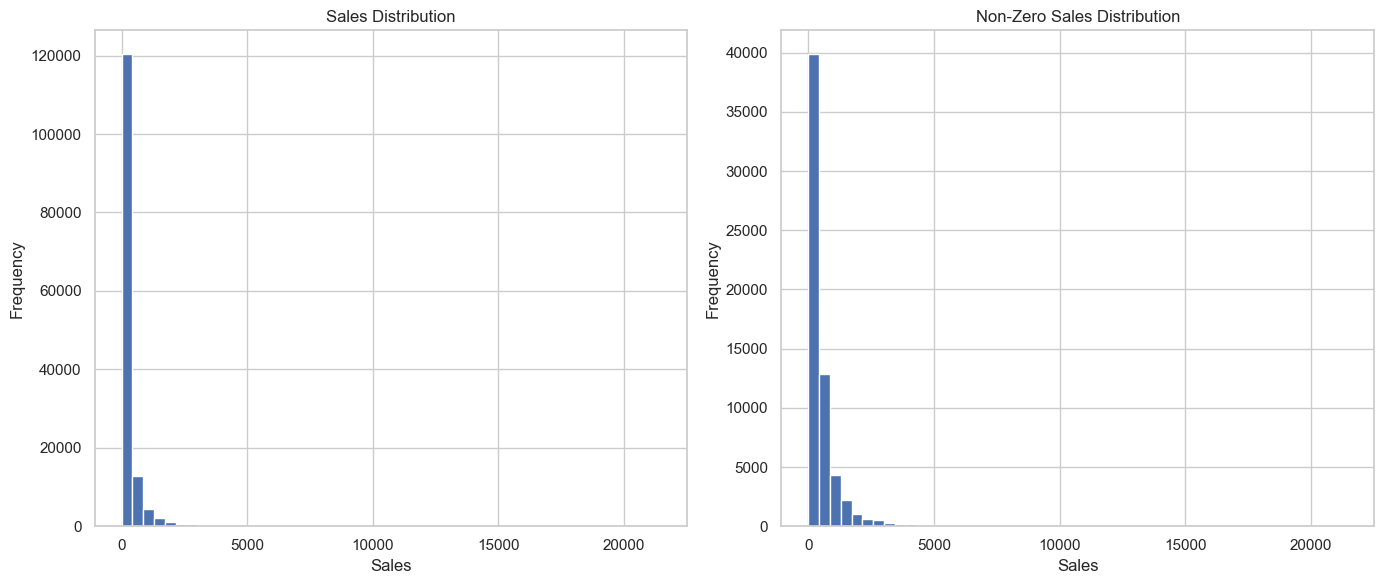

In [ ]:
# Let's examine the distribution of sales
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
df['Sales'].hist(bins=50)
plt.title('Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
df[df['Sales'] > 0]['Sales'].hist(bins=50)
plt.title('Non-Zero Sales Distribution')
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [58]:
# Count of zero sales
zero_sales_count = (df['Sales'] == 0).sum()
print(f"Zero sales count: {zero_sales_count} ({zero_sales_count/len(df)*100:.2f}%)")

Zero sales count: 80541 (56.22%)


In [146]:
# check Sales = 0 by year week
zero_sales_by_yearweek = df.groupby('YearWeek')['Sales'].apply(lambda x: (x == 0).sum()).reset_index(name='ZeroSalesCount')

zero_sales_by_yearweek

,YearWeek,ZeroSalesCount
0,2020-01,0
1,2020-02,75
2,2020-03,154
3,2020-04,213
4,2020-05,265
...,...,...
155,2022-51,970
156,2022-52,970
157,2023-01,970
158,2023-02,970


* Finding: Starting from 2022-46, there are 970 consitatnt records that Sales = 0
* The test period (2022-46 to 2023-02) has zero sales values might because it's expected to predict those values.

## Data preprocessing & Feature Engineer

In [60]:
# Convert YearWeek to datetime
df['Date'] = df['YearWeek'].apply(convert_yearweek)
df = df.sort_values(['Key', 'Date'])

In [61]:
# time-based features
df['year'] = df['Date'].dt.year
df['month'] = df['Date'].dt.month
df['week_of_year'] = df['Date'].dt.isocalendar().week
df['day_of_week'] = df['Date'].dt.dayofweek
df['day_of_month'] = df['Date'].dt.day
df['day_of_year'] = df['Date'].dt.dayofyear

In [63]:
# Create cyclical features for seasonal patterns
df = create_cyclical_features(df, 'week_of_year', 52)
df = create_cyclical_features(df, 'month', 12)
df = create_cyclical_features(df, 'day_of_week', 7)
df = create_cyclical_features(df, 'day_of_month', 30)
df = create_cyclical_features(df, 'day_of_year', 365)

### Feature Engineering

In [64]:
# Handle zero sales values for log transformation
df['Sales_log'] = np.log1p(df['Sales'])

In [66]:
# Create lag features for each Key
lag_periods = [1, 2, 3, 4, 8, 12, 16, 26, 52]
print(f"Creating lag features for periods: {lag_periods}")
for lag in lag_periods:
    df[f'sales_lag_{lag}'] = df.groupby('Key')['Sales'].shift(lag)
    df[f'sales_log_lag_{lag}'] = df.groupby('Key')['Sales_log'].shift(lag)

Creating lag features for periods: [1, 2, 3, 4, 8, 12, 16, 26, 52]


In [67]:
# Create rolling statistics
window_sizes = [4, 8, 12, 26]  # Different window sizes
print(f"Creating rolling features with window sizes: {window_sizes}")

for window in window_sizes:
    # Mean
    df[f'sales_rolling_mean_{window}'] = df.groupby('Key')['Sales'].transform(
        lambda x: x.rolling(window, min_periods=1).mean())

    # Standard deviation to capture volatility
    df[f'sales_rolling_std_{window}'] = df.groupby('Key')['Sales'].transform(
        lambda x: x.rolling(window, min_periods=1).std())

    # Min and Max to capture range
    df[f'sales_rolling_min_{window}'] = df.groupby('Key')['Sales'].transform(
        lambda x: x.rolling(window, min_periods=1).min())
    df[f'sales_rolling_max_{window}'] = df.groupby('Key')['Sales'].transform(
        lambda x: x.rolling(window, min_periods=1).max())

    # Expanding mean to capture long-term trend
    df[f'sales_expanding_mean_{window}'] = df.groupby('Key')['Sales'].transform(
        lambda x: x.expanding(min_periods=1).mean())

Creating rolling features with window sizes: [4, 8, 12, 26]


In [68]:
# Calculate difference features to capture trends
df['sales_diff_1'] = df.groupby('Key')['Sales'].diff(1)
df['sales_diff_4'] = df.groupby('Key')['Sales'].diff(4)
df['sales_diff_52'] = df.groupby('Key')['Sales'].diff(52)  # YOY difference

# Calculate percentage change
df['sales_pct_change_1'] = df.groupby('Key')['Sales'].pct_change(1)
df['sales_pct_change_4'] = df.groupby('Key')['Sales'].pct_change(4)
df['sales_pct_change_52'] = df.groupby('Key')['Sales'].pct_change(52)

In [69]:
# Create interaction features between promo variables and time
df['promo_month'] = df['PromoStatus'] * df['month']
df['discount_month'] = df['DiscountedPrice'] * df['month']
df['discount_week'] = df['DiscountedPrice'] * df['week_of_year']

In [ ]:
# # Encode categorical features
# cat_cols = ['Material', 'Customer', 'CustomerGroup', 'Category', 'PromoMethod', 'PromoStatus']

# for col in cat_cols:
#     le = LabelEncoder()
#     df[col] = le.fit_transform(df[col])

In [71]:
# Target encode high-cardinality variables
high_cardinality_cols = ['Material', 'Customer', 'CustomerGroup', 'Category']
for col in high_cardinality_cols:
    # Only use training data for encoding to prevent data leakage
    cutoff_date = pd.to_datetime('2022-11-14')  # Week 45 of 2022
    train_mask = df['Date'] < cutoff_date

    # Create mapping from train data
    train_data = df[train_mask]
    encoding_map = train_data.groupby(col)['Sales'].mean()

    # Apply encoding to all data
    df[f'{col}_target_encoded'] = df[col].map(encoding_map)

    # Fill missing values with global mean (for new categories in test set)
    global_mean = train_data['Sales'].mean()
    df[f'{col}_target_encoded'].fillna(global_mean, inplace=True)

### Train Test Spliting

In [156]:
# Split data into train/validation/test
print("\nSplitting data for model training...")
# Make sure the date column exists
# if 'Date' in df.columns:
#     cutoff_date = pd.to_datetime('2022-11-14')  # 2022-45 is week 45
#     train_mask = df['Date'] < cutoff_date
#     test_mask = (df['Date'] >= cutoff_date) & (df['YearWeek'] <= '2023-02')
# else:
#     # Alternative approach using YearWeek directly
#     print("Using YearWeek for splitting instead of Date")
train_mask = df['YearWeek'] < '2022-46'
test_mask = (df['YearWeek'] >= '2022-46') & (df['YearWeek'] <= '2023-02')

train_df = df[train_mask].copy()
test_df = df[test_mask].copy()

train_df = train_df.sort_values(['Key', 'YearWeek'])
test_df = test_df.sort_values(['Key', 'YearWeek'])

print(f"Train set: {train_df.shape}")
print(f"Test set: {test_df.shape}")


Splitting data for model training...
Train set: (133573, 89)
Test set: (8730, 89)


In [174]:
train_keys = set(train_df['Key'].unique())
test_keys = set(test_df['Key'].unique())
missing_keys = test_keys - train_keys

if missing_keys:
    print(f"WARNING: {len(missing_keys)} keys in test set not found in training data!")

### Prepare features and target

In [175]:
# Drop features that would cause data leakage
exclude_cols = ['Sales', 'Sales_log', 'YearWeek', 'Date', 'Key']
features = [col for col in df.columns if col not in exclude_cols]
features

['Material',
 'Customer',
 'CustomerGroup',
 'Category',
 'Week',
 'Month',
 'Qtr',
 'New_Year',
 'Christmas_Day',
 'Easter_Monday',
 'Other_Holidays',
 'DiscountedPrice',
 'PromoShipment',
 'Objective1',
 'Objective2',
 'PromoMethod',
 'PromoStatus',
 'year',
 'month',
 'week_of_year',
 'day_of_week',
 'day_of_month',
 'day_of_year',
 'week_of_year_sin',
 'week_of_year_cos',
 'month_sin',
 'month_cos',
 'day_of_week_sin',
 'day_of_week_cos',
 'day_of_month_sin',
 'day_of_month_cos',
 'day_of_year_sin',
 'day_of_year_cos',
 'sales_lag_1',
 'sales_log_lag_1',
 'sales_lag_2',
 'sales_log_lag_2',
 'sales_lag_3',
 'sales_log_lag_3',
 'sales_lag_4',
 'sales_log_lag_4',
 'sales_lag_8',
 'sales_log_lag_8',
 'sales_lag_12',
 'sales_log_lag_12',
 'sales_lag_16',
 'sales_log_lag_16',
 'sales_lag_26',
 'sales_log_lag_26',
 'sales_lag_52',
 'sales_log_lag_52',
 'sales_rolling_mean_4',
 'sales_rolling_std_4',
 'sales_rolling_min_4',
 'sales_rolling_max_4',
 'sales_expanding_mean_4',
 'sales_rolling

In [176]:
# Check for missing values
for df_subset in [train_df, test_df]:
    missing_values = df_subset[features].isnull().sum()
    cols_with_missing = missing_values[missing_values > 0]
    if len(cols_with_missing) > 0:
        print(f"\nColumns with missing values:")
        print(cols_with_missing)

        # Fill NAs with appropriate values
        for col in cols_with_missing.index:
            if 'lag' in col or 'rolling' in col or 'diff' in col or 'pct_change' in col:
                # For time-based features, use forward fill then backward fill
                df_subset[col].fillna(method='ffill', inplace=True)
                df_subset[col].fillna(method='bfill', inplace=True)
                # If still NA, use 0
                df_subset[col].fillna(0, inplace=True)
            else:
                # For other features, use median
                df_subset[col].fillna(df_subset[col].median(), inplace=True)


Columns with missing values:
sales_lag_1               784
sales_log_lag_1           784
sales_lag_2              1568
sales_log_lag_2          1568
sales_lag_3              2352
sales_log_lag_3          2352
sales_lag_4              3136
sales_log_lag_4          3136
sales_lag_8              6272
sales_log_lag_8          6272
sales_lag_12             9408
sales_log_lag_12         9408
sales_lag_16            12544
sales_log_lag_16        12544
sales_lag_26            20384
sales_log_lag_26        20384
sales_lag_52            40768
sales_log_lag_52        40768
sales_rolling_std_4       784
sales_rolling_std_8       784
sales_rolling_std_12      784
sales_rolling_std_26      784
sales_diff_1              784
sales_diff_4             3136
sales_diff_52           40768
sales_pct_change_1      47968
sales_pct_change_4      47442
sales_pct_change_52     67109
dtype: int64

Columns with missing values:
sales_lag_1               186
sales_log_lag_1           186
sales_lag_2               3

In [177]:
# Check for infinite values
inf_mask = np.isinf(train_df[features]).any(axis=1)
if inf_mask.any():
    print(f"Found {inf_mask.sum()} rows with infinite values. Replacing with NaN and then filling.")
    train_df[features] = train_df[features].replace([np.inf, -np.inf], np.nan)
    train_df[features].fillna(0, inplace=True)

inf_mask = np.isinf(test_df[features]).any(axis=1)
if inf_mask.any():
    print(f"Found {inf_mask.sum()} rows with infinite values in test set. Replacing.")
    test_df[features] = test_df[features].replace([np.inf, -np.inf], np.nan)
    test_df[features].fillna(0, inplace=True)

Found 47470 rows with infinite values. Replacing with NaN and then filling.
Found 12211 rows with infinite values in test set. Replacing.


In [178]:
# Get feature sets
X_train = train_df[features]
y_train = train_df['Sales']
X_test = test_df[features]
y_test = test_df['Sales']

# Check for highly correlated features in training set
X_train_reduced, dropped_features = remove_collinear_features(X_train, threshold=0.95)

# Remove the same features from test set
X_test_reduced = X_test.drop(columns=dropped_features)

Dropping 21 highly correlated features: ['Month', 'Qtr', 'Objective2', 'PromoStatus', 'week_of_year', 'day_of_year', 'month_sin', 'month_cos', 'day_of_year_sin', 'day_of_year_cos', 'sales_rolling_mean_8', 'sales_rolling_max_8', 'sales_expanding_mean_8', 'sales_rolling_mean_12', 'sales_rolling_max_12', 'sales_expanding_mean_12', 'sales_rolling_mean_26', 'sales_rolling_max_26', 'sales_expanding_mean_26', 'discount_month', 'discount_week']


##  Model Training

In [179]:
# # Baseline model
# # LightGBM with MAE optimization
# params = {
#     'objective': 'regression_l1',
#     'learning_rate': 0.05,
#     'num_leaves': 31,
#     'n_estimators': 200,
#     'random_state': 42
# }

# model = lgb.LGBMRegressor(**params)
# model.fit(X_train, y_train)

In [180]:
print("\nTraining LightGBM model...")

# Define time-based cross-validation strategy
tscv = TimeSeriesSplit(n_splits=5)

# Define parameter grid for hyperparameter tuning
param_grid = {
    'objective': ['regression_l1'],  # L1 loss is more robust to outliers
    'boosting_type': ['gbdt', 'dart'],
    'num_leaves': [31, 63, 127],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 200, 300],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
    'min_child_samples': [5, 10, 20]
}

# Initialize LightGBM model
lgbm = lgb.LGBMRegressor(random_state=42)


Training LightGBM model...


In [181]:
# Perform randomized search CV with time series splits
print("Optimizing hyperparameters...")
cv = RandomizedSearchCV(
    estimator=lgbm,
    param_distributions=param_grid,
    n_iter=10,
    scoring='neg_mean_absolute_error',
    cv=tscv,
    random_state=42,
    n_jobs=-1
)

# Fit the model
cv.fit(X_train_reduced, y_train)

# Get best parameters
print("\nBest parameters:")
print(cv.best_params_)

Optimizing hyperparameters...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.027526 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9604
[LightGBM] [Info] Number of data points in the train set: 114618, number of used features: 58
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf

Best parameters:
{'subsample': 0.9, 'reg_lambda': 0, 'reg_alpha': 0, 'objective': 'regression_l1', 'num_leaves': 63, 'n_estimators': 300, 'min_child_samples': 10, 'learning_rate': 0.1, 'colsample_bytree': 1.0, 'boosting_type': 'gbdt'}


In [182]:
# Train final model with best parameters
final_model = lgb.LGBMRegressor(**cv.best_params_, random_state=42)

In [183]:
# Create validation set for early stopping
# Since we're dealing with time series data, use the last portion as validation
print("Creating validation set for early stopping...")

# Simple approach: use the last 10% of the training data as validation
val_size = int(X_train_reduced.shape[0] * 0.1)
X_train_inner = X_train_reduced.iloc[:-val_size]
y_train_inner = y_train.iloc[:-val_size]
X_val = X_train_reduced.iloc[-val_size:]
y_val = y_train.iloc[-val_size:]

print(f"Training set size: {X_train_inner.shape[0]}, Validation set size: {X_val.shape[0]}")

Creating validation set for early stopping...
Training set size: 103157, Validation set size: 11461


In [184]:
# Fit the model - try with early stopping if available, otherwise fall back to standard fit
print("Training final model...")
try:
    # Try modern LightGBM API with callbacks
    final_model.fit(
        X_train_inner,
        y_train_inner,
        eval_set=[(X_val, y_val)],
        eval_metric='mae',
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(period=0)  # Suppress evaluation logging
        ]
    )
    print("Model trained with early stopping")
except (TypeError, AttributeError) as e:
    print(f"Warning: {e}")
    print("Falling back to standard fit method")
    # Fall back to an older/simpler API
    try:
        # Try with early_stopping_rounds as parameter (older API)
        final_model.fit(
            X_train_inner,
            y_train_inner,
            eval_set=[(X_val, y_val)],
            eval_metric='mae',
            early_stopping_rounds=50,
            verbose=False
        )
        print("Model trained with early_stopping_rounds parameter")
    except TypeError:
        # If that also fails, use basic fit without early stopping
        final_model.fit(X_train_reduced, y_train)
        print("Model trained with basic fit (no early stopping)")

Training final model...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.024328 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9553
[LightGBM] [Info] Number of data points in the train set: 103157, number of used features: 58
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Model trained with early stopping


## Prediction & Evaluation

In [185]:
print("\nMaking predictions...")
y_pred = final_model.predict(X_test_reduced)


Making predictions...


In [186]:
test_df['Predicted_Sales'] = y_pred
predictions_output = test_df[['Key', 'YearWeek', 'Predicted_Sales']]
predictions_output.to_csv('sales_predictions.csv', index=False)

print(f"\nPredictions saved to 'sales_predictions.csv'")
print(f"Sample of predictions:")
print(predictions_output.head(10))


Predictions saved to 'sales_predictions.csv'
Sample of predictions:
        Key YearWeek  Predicted_Sales
38625  67_1  2022-13        -1.181950
38626  67_1  2022-14       560.096569
38627  67_1  2022-15         0.000000
38628  67_1  2022-16         0.000000
38629  67_1  2022-17       559.983473
38630  67_1  2022-18         0.000000
38631  67_1  2022-19         0.000000
38632  67_1  2022-20         0.000000
38633  67_1  2022-21         0.000000
38634  67_1  2022-22         0.000000


In [187]:
# Evaluate performance
wmape = calculate_wmape(y_test, y_pred)
bias = calculate_bias(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"Evaluation metrics:")
print(f"WMAPE: {wmape:.4f}")
print(f"Bias: {bias:.4f}")
print(f"MAE: {mae:.4f}")

Evaluation metrics:
WMAPE: 0.9588
Bias: -0.0009
MAE: 10.8411


### In case this is a true forecasting scenario, prediction output from here

In [188]:
y_pred = np.maximum(y_pred, 0)

print("\nTest set contains zeros as placeholders for future sales")
print(f"Number of predictions: {len(y_pred)}")
print(f"Mean prediction: {np.mean(y_pred):.2f}")
print(f"Min prediction: {np.min(y_pred):.2f}")
print(f"Max prediction: {np.max(y_pred):.2f}")
print(f"Sum of all predictions: {np.sum(y_pred):.2f}")


Test set contains zeros as placeholders for future sales
Number of predictions: 28655
Mean prediction: 263.21
Min prediction: 0.00
Max prediction: 16347.97
Sum of all predictions: 7542384.23


### Feature Importance

In [190]:
feature_importance = pd.DataFrame({
    'Feature': X_train_reduced.columns,
    'Importance': final_model.feature_importances_
})
feature_importance = feature_importance.sort_values('Importance', ascending=False)
print("\nTop 10 important features:")
print(feature_importance.head(10))


Top 10 important features:
                 Feature  Importance
53          sales_diff_4        2383
52          sales_diff_1        1875
29           sales_lag_4        1349
41  sales_rolling_mean_4        1295
44   sales_rolling_max_4        1239
23           sales_lag_1        1140
56    sales_pct_change_4        1102
55    sales_pct_change_1        1023
43   sales_rolling_min_4         965
42   sales_rolling_std_4         742


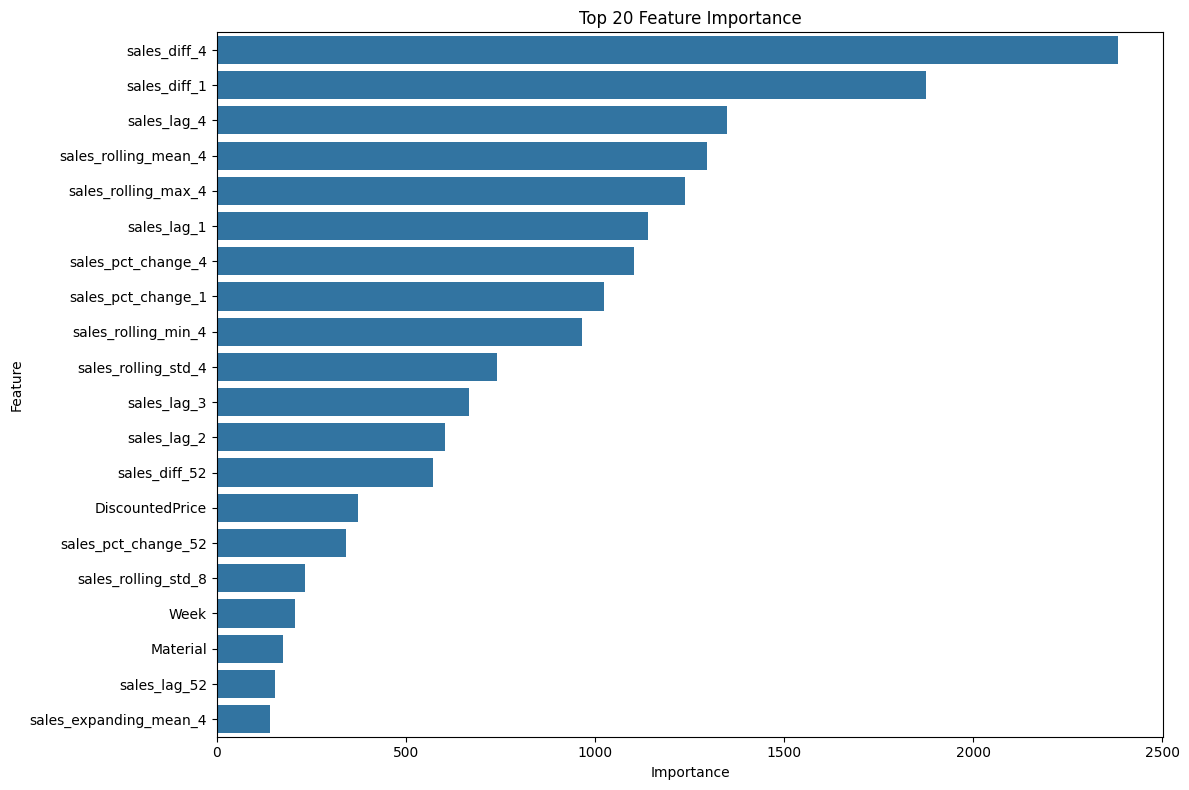

In [191]:
# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(20))
plt.title('Top 20 Feature Importance')
plt.tight_layout()
plt.show()
plt.savefig('feature_importance.png')
plt.close()

In [192]:
# Error Analysis
test_df['prediction'] = y_pred
test_df['error'] = test_df['Sales'] - test_df['prediction']
test_df['abs_error'] = np.abs(test_df['error'])

In [193]:
# Error by key
key_error = test_df.groupby('Key')['abs_error'].mean().sort_values(ascending=False)
print(f"\nTop 10 keys with highest average error:")
print(key_error.head(10))


Top 10 keys with highest average error:
Key
72_10    325.928980
79_10    179.481920
72_6     124.892804
70_10     97.719255
72_26     87.340601
73_8      57.452623
9_10      50.672490
72_15     44.314518
74_1      38.867990
79_16     37.513115
Name: abs_error, dtype: float64


In [194]:
# Error by week
week_error = test_df.groupby('YearWeek')['abs_error'].mean().sort_values(ascending=False)
print(f"\nAverage error by week:")
print(week_error)


Average error by week:
YearWeek
2022-31    4.423265e+01
2020-04    3.611054e+01
2022-41    3.227010e+01
2020-05    2.685093e+01
2021-29    2.502879e+01
               ...     
2022-51    1.488554e-02
2022-52    1.425469e-02
2022-50    2.072840e-03
2023-01    4.261998e-04
2023-03    5.744190e-09
Name: abs_error, Length: 160, dtype: float64


## Output Prediction

In [195]:
# Save predictions to CSV
predictions = test_df[['Key', 'YearWeek', 'Sales', 'prediction']]
predictions.to_csv('sales_predictions.csv', index=False)

print("\nPredictions saved to 'sales_predictions.csv'")


Predictions saved to 'sales_predictions.csv'


## Push changes to Github

In [201]:
git_manager.list_branches()

['main']

In [202]:
git_manager.add_all()

Added all changes to staging area


In [204]:
status = git_manager.status()
if "nothing to commit" not in status:
    git_manager.add_all()
    git_manager.commit("update evaluation")
else:
    print("No changes to commit")

No changes to commit
